<a href="https://colab.research.google.com/github/Pernach/PythonProjects/blob/main/Pitch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import lstm 
from math import cos, sin, exp

In [2]:
def discretize_F(F, G, dt):
  result1 = torch.eye(2,2) + F*dt
  result2 = (G*dt).T
  return result1, result2

In [3]:
# Определим фильтр
def Filter_d(array, alpha, betta, sigma, dt, R):
  F = torch.tensor([[0, 1], [-(alpha**2 + betta**2), -2*alpha]]) # матрица динамики
  G = torch.tensor([[0, sigma*np.sqrt(4*alpha*(alpha**2 + betta**2))]]) # Матрица порождающих шумов
  H = torch.tensor([[1], [0]]) # Матрица состояния
  Fd, Gd = discretize_F(F, G, dt) # Дискретизация первого порядка (достаточно для этого времени дискретизации в сравнении с периодом качки)
  P = torch.tensor([[sigma**2, 0], [0, (sigma**2)/(alpha**2 + betta**2)]]) # Начальное состояние фильтра
  Rd = R/dt
  res0 = (torch.sqrt(P)).double().mm(torch.normal(mean = 0.0, std = 1.0, size = (2,1)).double()) #Первое значение
  #w = torch.normal(mean = 0.0, std = 1/np.sqrt(dt), size = (1,len(array[0])))
  result = torch.zeros(2,len(array[0]))
  result[:,0] = res0.T
  for i in range(1,len(array[0])):
    l = torch.tensor([[result[0,(i-1)]],[result[1,(i-1)]]]) 
    s = Fd.double().mm(l.double())  
    k = Gd.double() * array[:,i]
    result[:,i] = (s + k).T
  return result

In [4]:
omega = 0.6
dt = 0.05
w = torch.normal(mean = 0.0, std = 1/np.sqrt(dt), size = (1,80000))
xx = Filter_d(w, 0.21*0.98*omega, 0.98*omega, 0.5, dt, 10e-10)

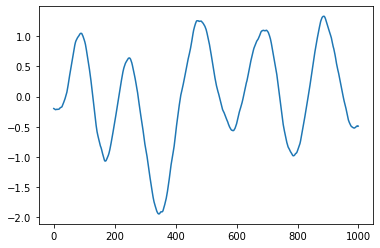

In [5]:
plt.plot(xx[0,4000:5000])

In [44]:
def Kalman(Y, sigma, om, dt, R, Q):
  alpha = 0.21*0.98*om
  betta = 0.98*om
  Qd = Q/dt
  Rd = R/dt
  F = torch.tensor([[0, 1], [-(alpha**2 + betta**2), -2*alpha]]).double() # матрица динамики
  G = torch.tensor([[0, sigma*np.sqrt(4*alpha*(alpha**2 + betta**2))]]).double() # Матрица порождающих шумов
  H = torch.tensor([[1], [0]]).double() # Матрица состояния
  Fd, Gd = discretize_F(F, G, dt) # Дискретизация первого порядка (достаточно для этого времени дискретизации в сравнении с периодом качки)
  result = torch.zeros(2,len(Y[0]))
  Px = torch.zeros(2,2).double()
  for i in range(1,len(Y[0])):
    S = Fd.mm(Px).mm(Fd.T) + (Gd * Qd).double().mm(Gd.T)
    Kf = S.mm(H).mm((H.T.mm(S).mm(H) + Rd)**(-1)) 
    Px = (torch.eye(2) - Kf.mm(H.T)).mm(S)
    tt = torch.tensor([[result[0,(i-1)]],[result[1,(i-1)]]])
    result[:,i] = (Fd.mm(tt.double()) + Kf * (Y[0,i-1] - H.T.mm(Fd.mm(tt.double())))).T
  return result

In [45]:
xy = Kalman(xx, 0.5, 0.6, 0.05, 10e-10, 1)

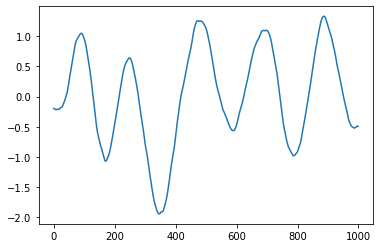

In [47]:
plt.plot(xy[0,4000:5000])

In [85]:
alpha = 0.21*0.98*omega
betta = 0.98*omega
dt = 0.05
tetta = 0.05
tetta_dt = tetta / dt
Corr_mx = torch.tensor([[cos(betta * tetta_dt) + (alpha / betta) * sin(betta * tetta_dt), (1/betta)*sin(betta*tetta_dt)],[(-(alpha**2+betta**2)/betta)*sin(betta*tetta_dt), cos(betta*tetta_dt)-(alpha/(betta)*sin(betta*tetta_dt))]])
Corr_fun = exp(-alpha * tetta_dt)*Corr_mx

In [86]:
Predict_FK = torch.zeros(2, len(xy[0]))
for num in range(len(xy[0])):
  xy_b = torch.tensor([[xy[0,num]],[xy[1,num]]])
  Predict_FK[:,num] = Corr_fun.mm(xy_b).T

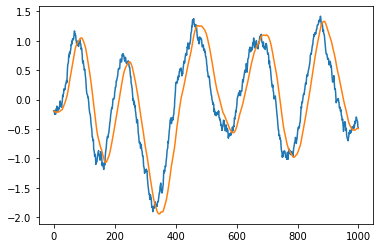

In [87]:
plt.plot(Predict_FK[0,4000:5000])
plt.plot(xy[0,4000:5000])